In [66]:
library(ape)
library(jsonlite)
library(sitePath)
library(aplot)
library(ggplot2)
library(ggrepel)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

TREES_DIR <- "Trees"
STRUCTURES_DIR <- "Structures"
ANTIGENICITY <- "Antigenicity"

H1N1_HA_NAME <- "H1N1_HA"
H3N2_HA_NAME <- "H3N2_HA"

In [2]:
treeDir <- file.path(TREES_DIR, H1N1_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "MK615591")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [3]:
paths <- lineagePath(tree, 0.01)
mutations <- fixationSites(paths)

In [4]:
snpTracing <- as.phylo(mutations)

x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 8 
Found number of nodes: m = 6 
Done.


In [59]:
x <- readLines(file.path(STRUCTURES_DIR, "distance.mat"))[-1]

distMatrix <- lapply(strsplit(x, " "), function(i) {
    as.numeric(i[i != ""][-2])
})
distMatrix <- do.call(rbind, distMatrix)
distMatrix <- as.data.frame(distMatrix[, -1], row.names = distMatrix[, 1])
colnames(distMatrix) <- rownames(distMatrix)

In [60]:
pca <- prcomp(distMatrix)

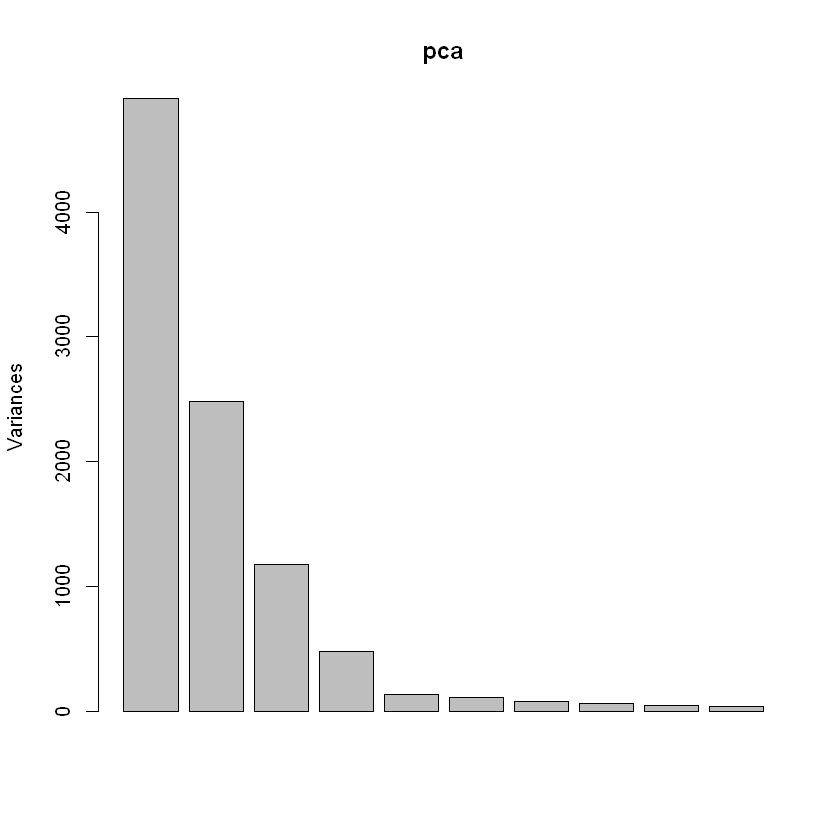

In [61]:
plot(pca)

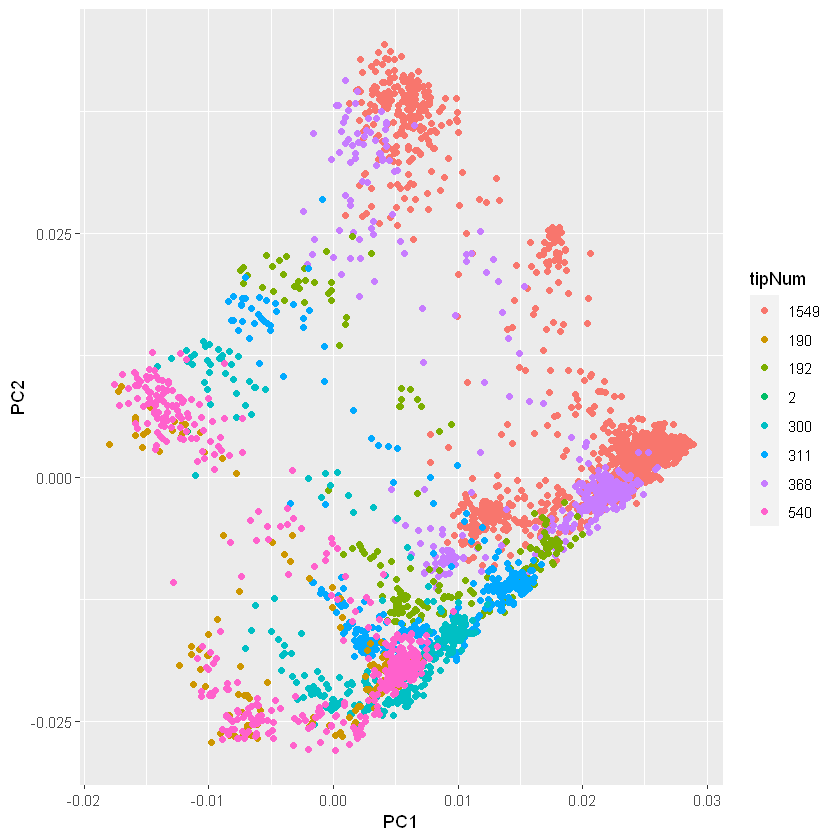

In [62]:
y <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    tipNames <- as.character(tips)
    tipNames <- tipNames[tipNames %in% rownames(pca[["rotation"]])]
    pc1 <- pca[["rotation"]][, c("PC1", "PC2"), drop = FALSE][tipNames, , drop = FALSE]
    data.frame("PC1" = pc1[, "PC1"], "PC2" = pc1[, "PC2"], "tipNum" = as.character(length(tips)))
})
y <- do.call(rbind, y)

y[["tipNum"]] <- as.factor(y[["tipNum"]])

ggplot(y, aes(PC1, PC2, color=tipNum)) + geom_point()

In [63]:
x <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    tipNames <- as.character(tips)
    tipNames <- tipNames[tipNames %in% rownames(pca[["rotation"]])]
    pc1 <- pca[["rotation"]][, "PC1", drop = FALSE][tipNames, , drop = FALSE]
    data.frame("PC1" = pc1, "tipNum" = as.character(length(tips)))
})
x <- do.call(rbind, x)

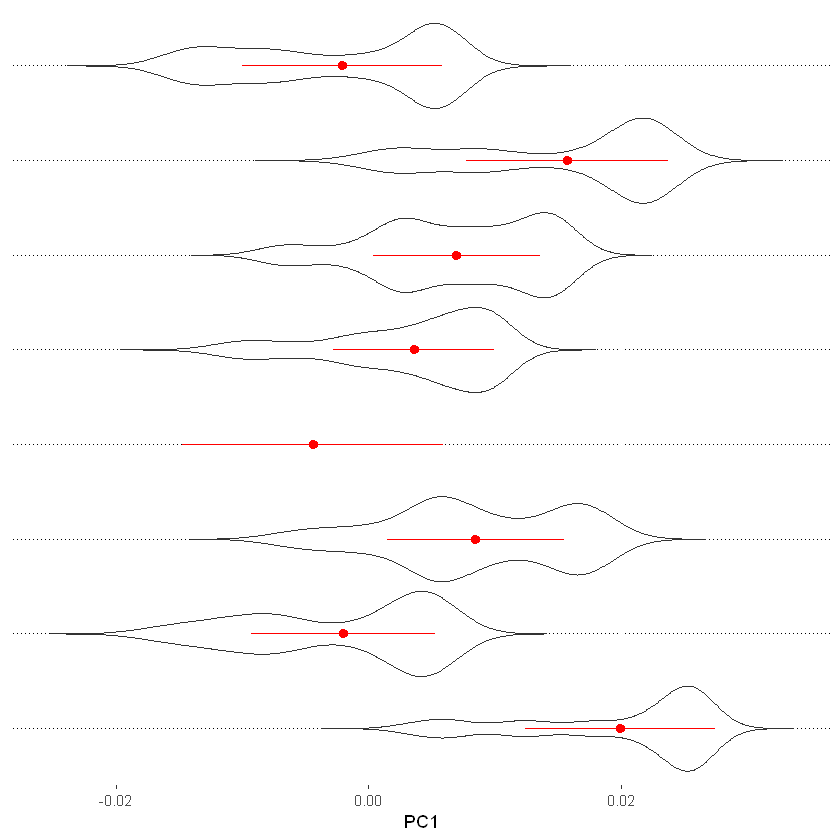

In [64]:
p1 <- ggplot(x, aes(PC1, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

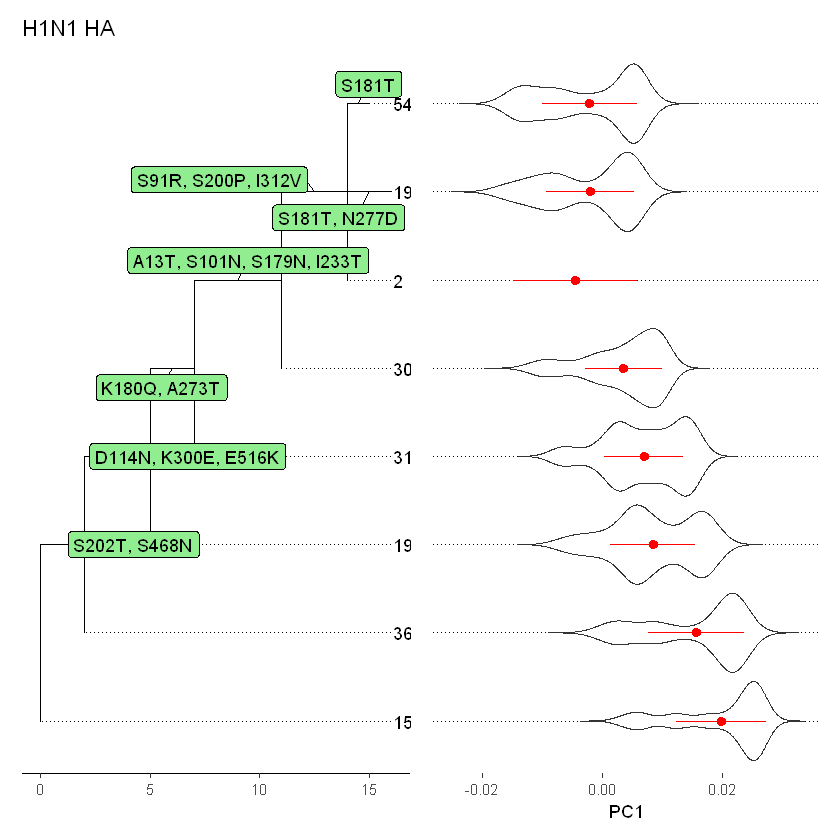

In [65]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0, na.rm = TRUE) + 
    theme_tree2() +
    ggtitle("H1N1 HA")

p <- p1 %>% insert_left(p)
p

In [33]:
x <- read.csv(file.path(ANTIGENICITY, "H1N1_antigenRelation"), header = FALSE, sep = "\t")
x[which(x[, 3] == "Min"), 3] <- 0
oddsRatio <- as.double(x[, 3])
x[, 3] <- oddsRatio / (oddsRatio + 1)

In [47]:
antiMatrix <- reshape2::dcast(x, V1 ~ V2, value.var = "V3", fill = 1)
rownames(antiMatrix) <- antiMatrix[, "V1"]
antiMatrix <- antiMatrix[, -1]

In [49]:
for (seqName in intersect(rownames(antiMatrix), colnames(antiMatrix))) {
    antiMatrix[seqName, seqName] <- 0
}

In [51]:
pca <- prcomp(antiMatrix)

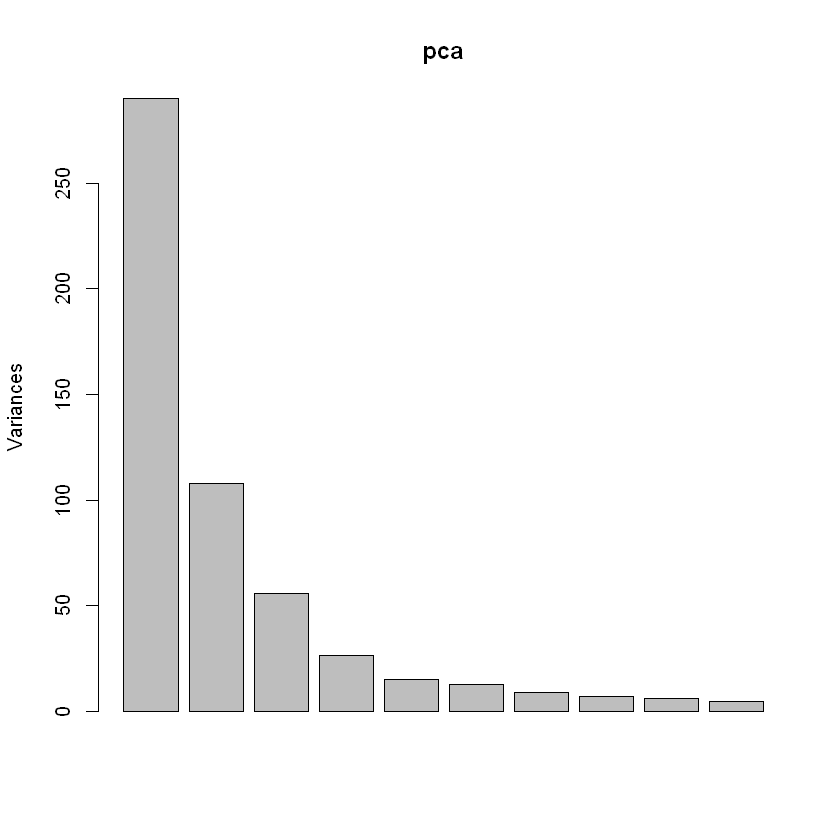

In [52]:
plot(pca)

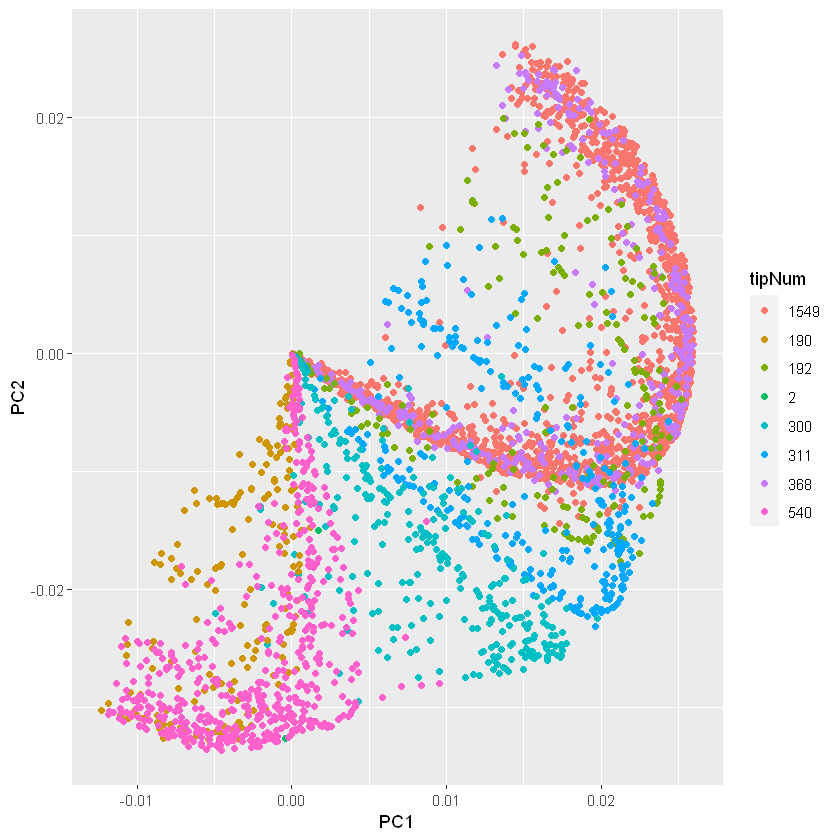

In [58]:
y <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    tipNames <- tree[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(pca[["rotation"]])]
    pc1 <- pca[["rotation"]][, c("PC1", "PC2"), drop = FALSE][tipNames, , drop = FALSE]
    data.frame("PC1" = pc1[, "PC1"], "PC2" = pc1[, "PC2"], "tipNum" = as.character(length(tips)))
})
y <- do.call(rbind, y)

y[["tipNum"]] <- as.factor(y[["tipNum"]])

ggplot(y, aes(PC1, PC2, color=tipNum)) + geom_point()

In [55]:
x <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    tipNames <- tree[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(pca[["rotation"]])]
    pc1 <- pca[["rotation"]][, "PC1", drop = FALSE][tipNames, , drop = FALSE]
    data.frame("PC1" = pc1, "tipNum" = as.character(length(tips)))
})
x <- do.call(rbind, x)

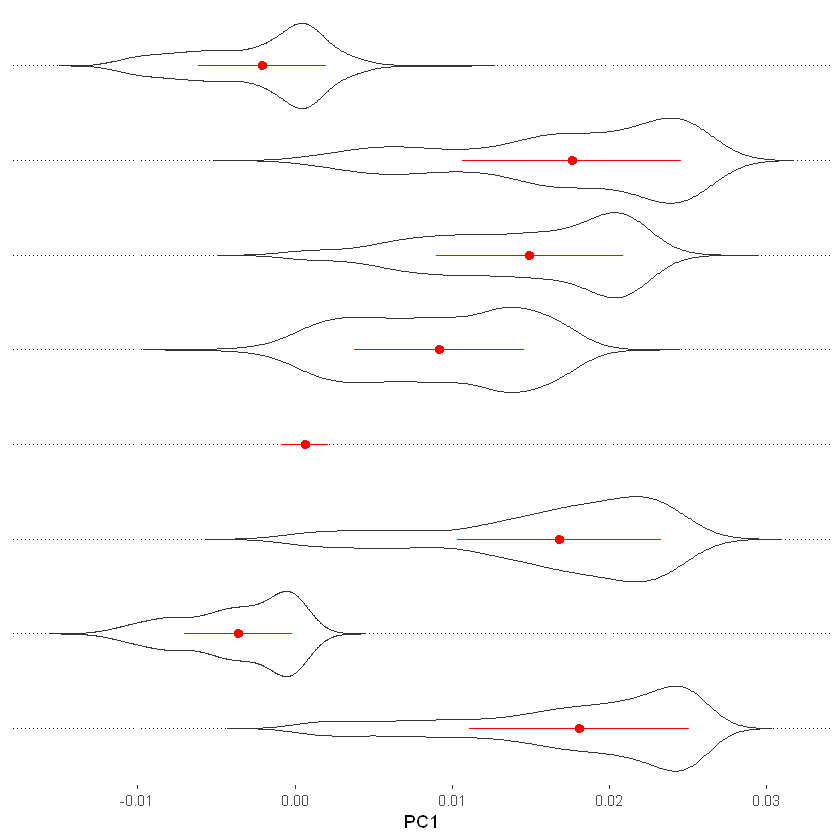

In [56]:
p1 <- ggplot(x, aes(PC1, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

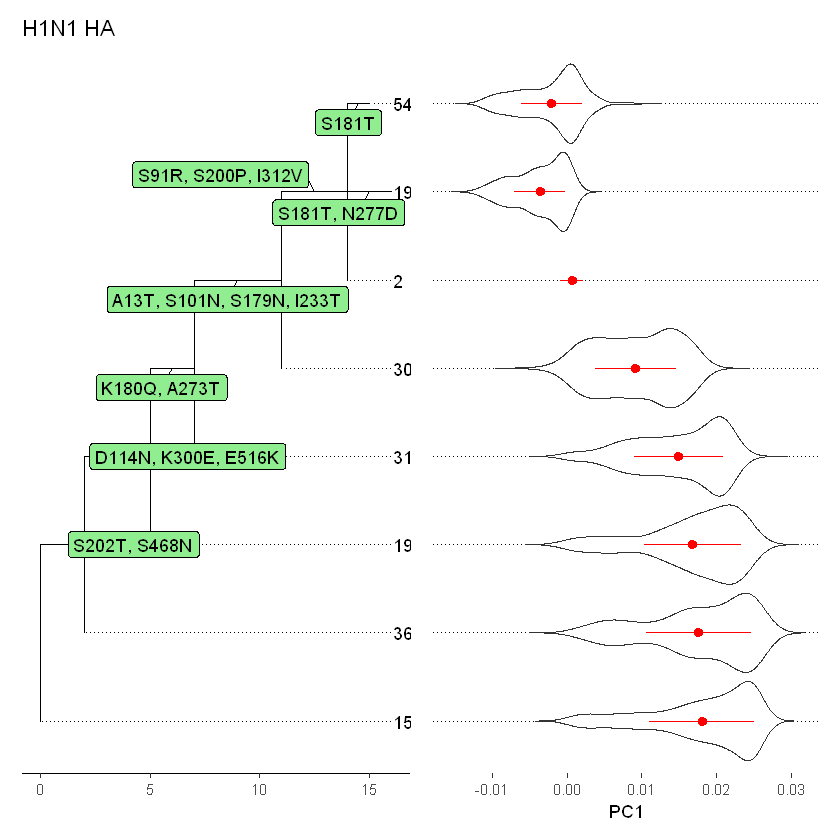

In [57]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0, na.rm = TRUE) + 
    theme_tree2() +
    ggtitle("H1N1 HA")

p <- p1 %>% insert_left(p)
p

In [68]:
treeDir <- file.path(TREES_DIR, H3N2_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "AB284320")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [69]:
paths <- lineagePath(tree, 0.01)
mutations <- fixationSites(paths)

In [70]:
snpTracing <- as.phylo(mutations)

x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 8 
Found number of nodes: m = 6 
Done.


In [71]:
x <- read.csv(file.path(ANTIGENICITY, "H3N2_antigenRelation"), header = FALSE, sep = "\t")
x[which(x[, 3] == "Min"), 3] <- 0
oddsRatio <- as.double(x[, 3])
x[, 3] <- oddsRatio / (oddsRatio + 1)

In [72]:
antiMatrix <- reshape2::dcast(x, V1 ~ V2, value.var = "V3", fill = 1)
rownames(antiMatrix) <- antiMatrix[, "V1"]
antiMatrix <- antiMatrix[, -1]

In [73]:
for (seqName in intersect(rownames(antiMatrix), colnames(antiMatrix))) {
    antiMatrix[seqName, seqName] <- 0
}

In [74]:
pca <- prcomp(antiMatrix)

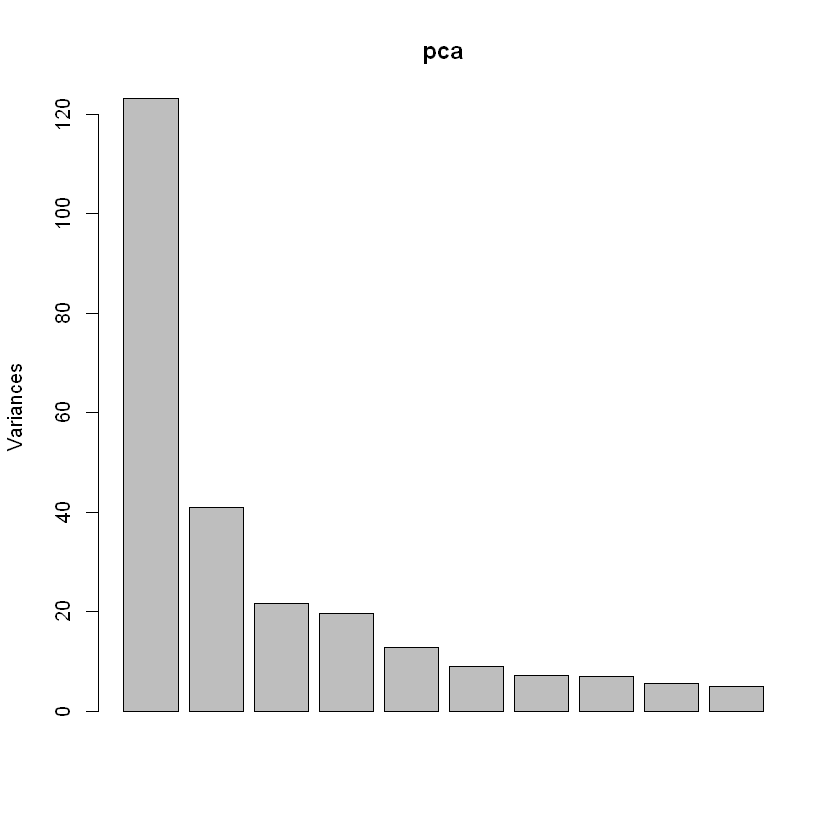

In [75]:
plot(pca)

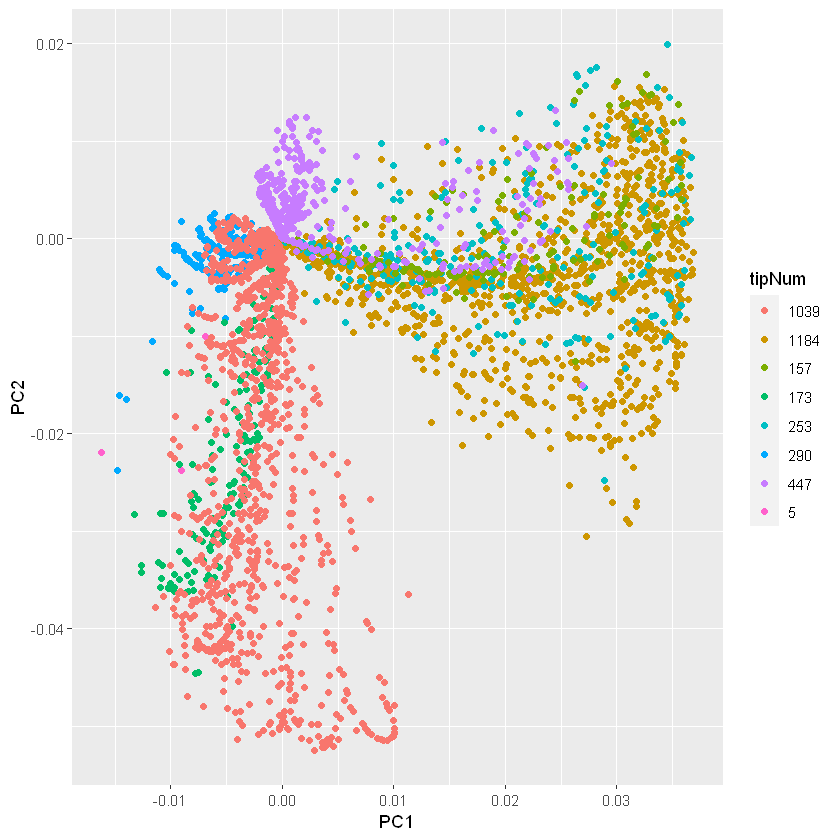

In [79]:
y <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    tipNames <- tree[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(pca[["rotation"]])]
    pc1 <- pca[["rotation"]][, c("PC1", "PC2"), drop = FALSE][tipNames, , drop = FALSE]
    data.frame("PC1" = pc1[, "PC1"], "PC2" = pc1[, "PC2"], "tipNum" = as.character(length(tips)))
})
y <- do.call(rbind, y)

y[["tipNum"]] <- as.factor(y[["tipNum"]])

ggplot(y, aes(PC1, PC2, color=tipNum)) + geom_point()

In [76]:
x <- lapply(attr(snpTracing, "tipClusters"), function(tips) {
    tipNames <- tree[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(pca[["rotation"]])]
    pc1 <- pca[["rotation"]][, "PC1", drop = FALSE][tipNames, , drop = FALSE]
    data.frame("PC1" = pc1, "tipNum" = as.character(length(tips)))
})
x <- do.call(rbind, x)

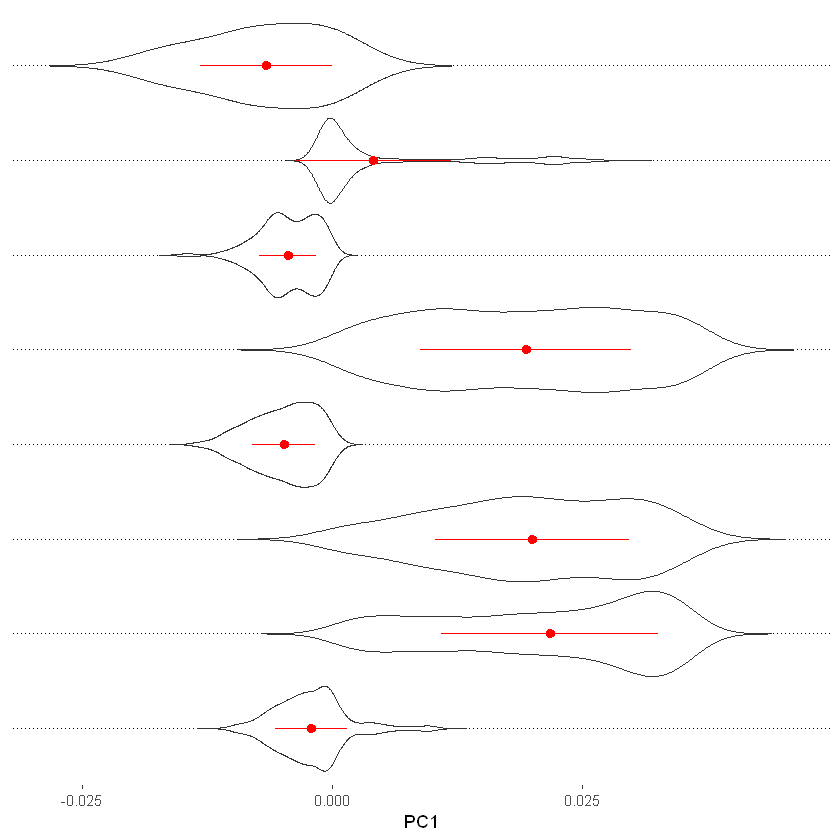

In [77]:
p1 <- ggplot(x, aes(PC1, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

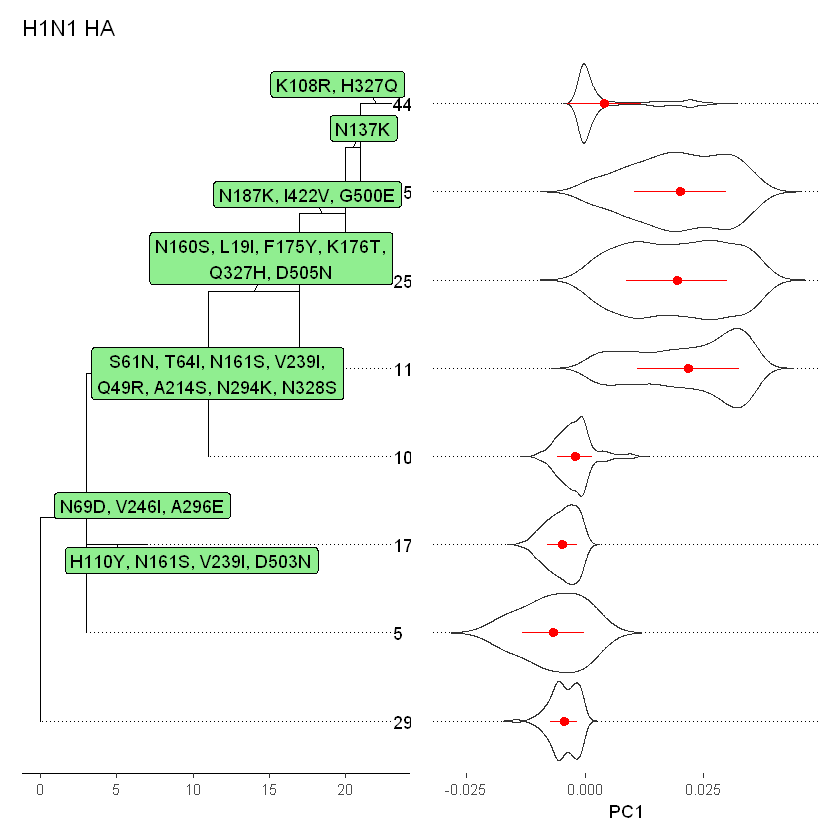

In [78]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0, na.rm = TRUE) + 
    theme_tree2() +
    ggtitle("H1N1 HA")

p <- p1 %>% insert_left(p)
p